In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
sns.set_theme()

In [3]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import ToTensor
import torch.optim as optim

In [4]:
#! Hyperparameters

# 1 layer of 50 neurons
# loss function: mean root square error
# optimizer: stochastic gradient descent
# epocs = 200

batch_size = 64
validation = .2
learning_rate = .01
seed = 42 # the answer to life, the universe & everything
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

In [5]:
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [17]:
df1 = pd.read_csv("Data/Processed/data_t1.csv")
X1 = df1.loc[:, df1.columns != 'glucose_t+1']
y1 = df1["glucose_t+1"]

df2 = pd.read_csv("Data/Processed/data_t2.csv")
X2 = df2.loc[:, df2.columns != 'glucose_t+2']
y2 = df2["glucose_t+2"]

df3 = pd.read_csv("Data/Processed/data_t3.csv")
X3 = df3.loc[:, df3.columns != 'glucose_t+3']
y3 = df3["glucose_t+3"]

In [18]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X3, y3, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.2)

train_data = TabularDataset(X_train, y_train)
val_data = TabularDataset(X_val, y_val)
test_data = TabularDataset(X_test, y_test)

In [19]:
train_loader = DataLoader(train_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)
validation_loader = DataLoader(val_data, batch_size=batch_size) 

In [20]:
# Define the Neural Network
class BaseLine(nn.Module):
    def __init__(self, input_dim):
        super(BaseLine, self).__init__()
        self.fc = nn.Linear(input_dim, 50)
        self.output = nn.Linear(50, 1)

    def forward(self, x):
        x = torch.relu(self.fc(x))
        return self.output(x)

# Define MAPE/MARD Loss function
def MAPELoss(preds, targets, epsilon = 1e-8): # epsilon prevents division by 0
    return torch.mean(torch.abs((targets - preds) / (targets + epsilon))) * 100

In [21]:
# Initialize model, optimizer
input_dim = X.shape[1]
model = BaseLine(input_dim=input_dim)
optimizer = optim.SGD(model.parameters())

# Training & Validation
num_epochs = 400
train_loss_mape = []
val_loss_mape = []

In [22]:
list(model.parameters())

[Parameter containing:
 tensor([[ 0.2703,  0.2935, -0.0828,  0.3248, -0.0775,  0.0713, -0.1721,  0.2076],
         [ 0.3117, -0.2594,  0.3073,  0.0662,  0.2612,  0.0479,  0.1705, -0.0499],
         [ 0.2725,  0.0523, -0.1651,  0.0901, -0.1629, -0.0415, -0.1436,  0.2345],
         [-0.2791, -0.1630, -0.0998, -0.2126,  0.0334, -0.3492,  0.3193, -0.3003],
         [ 0.2730,  0.0588, -0.1148,  0.2185,  0.0551,  0.2857,  0.0387, -0.1115],
         [ 0.0950, -0.0959,  0.1488,  0.3157,  0.2044, -0.1546,  0.2041,  0.0633],
         [ 0.1795, -0.2155, -0.3500, -0.1366, -0.2712,  0.2901,  0.1018,  0.1464],
         [ 0.1118, -0.0062,  0.2767, -0.2512,  0.0223, -0.2413,  0.1090, -0.1218],
         [ 0.1083, -0.0737,  0.2932, -0.2096, -0.2109, -0.2109,  0.3180,  0.1178],
         [ 0.3402, -0.2918, -0.3507, -0.2766, -0.2378,  0.1432,  0.1266,  0.2938],
         [-0.1826, -0.2410,  0.1876, -0.1429,  0.2146, -0.0839,  0.2022, -0.2747],
         [-0.1784,  0.1078,  0.0747, -0.0901,  0.2107,  0.2403, 

In [23]:
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_y = batch_y.view(-1, 1).float()
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = MAPELoss(outputs, batch_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    train_loss_mape.append(avg_train_loss)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for val_X, val_y in validation_loader:
            val_y = val_y.view(-1, 1).float()
            preds = model(val_X)
            loss = MAPELoss(preds, val_y)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(validation_loader)
    val_loss_mape.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs} | Train MAPE: {avg_train_loss:.4f}% | Val MAPE: {avg_val_loss:.4f}%")



Epoch 1/400 | Train MAPE: 21.9303% | Val MAPE: 18.6998%
Epoch 2/400 | Train MAPE: 15.3871% | Val MAPE: 13.1070%
Epoch 3/400 | Train MAPE: 14.2229% | Val MAPE: 12.7809%
Epoch 4/400 | Train MAPE: 13.6036% | Val MAPE: 13.0940%
Epoch 5/400 | Train MAPE: 13.4022% | Val MAPE: 13.0413%
Epoch 6/400 | Train MAPE: 13.2737% | Val MAPE: 12.8281%
Epoch 7/400 | Train MAPE: 13.1688% | Val MAPE: 12.9845%
Epoch 8/400 | Train MAPE: 13.0828% | Val MAPE: 13.4053%
Epoch 9/400 | Train MAPE: 13.1206% | Val MAPE: 12.4040%
Epoch 10/400 | Train MAPE: 13.1856% | Val MAPE: 12.8245%
Epoch 11/400 | Train MAPE: 13.1881% | Val MAPE: 12.3442%
Epoch 12/400 | Train MAPE: 13.0223% | Val MAPE: 12.0301%
Epoch 13/400 | Train MAPE: 12.9386% | Val MAPE: 12.6198%
Epoch 14/400 | Train MAPE: 13.1892% | Val MAPE: 12.5007%
Epoch 15/400 | Train MAPE: 13.0233% | Val MAPE: 12.1462%
Epoch 16/400 | Train MAPE: 12.8856% | Val MAPE: 12.2915%
Epoch 17/400 | Train MAPE: 13.0416% | Val MAPE: 12.0669%
Epoch 18/400 | Train MAPE: 13.0484% | Va

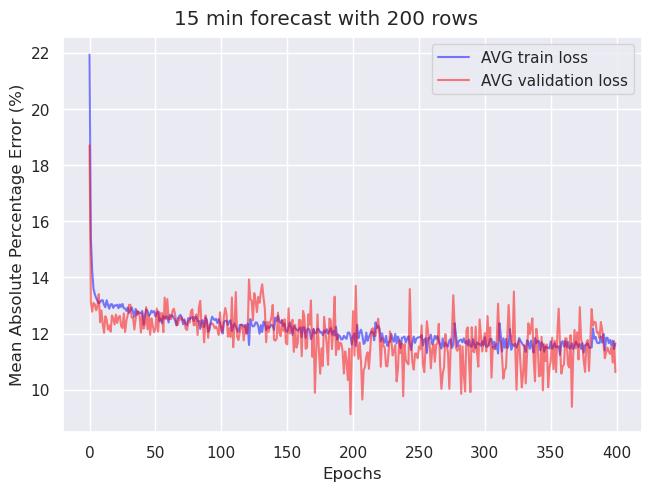

In [ ]:
fig, ax = plt.subplots(layout = "constrained")
ax.plot(train_loss_mape, color = "blue", label = "AVG train loss", alpha = .5)
ax.plot(val_loss_mape, color = "red", label = "AVG validation loss", alpha = .5)
ax.set_xlabel("Epochs")
ax.set_ylabel("Mean Absolute Percentage Error (%)")
fig.suptitle("15 min forecast with 200 rows")
plt.legend()
plt.savefig("Figures/simple_nn_15_min_200_rows.png", format = "png")
plt.show()